# SSD 训练过程 mAP 变化曲线可视化

对比两个模型的训练过程：
1. **原始 Anchor 模型** (Default Anchor)
2. **K-means++ 优化 Anchor 模型** (K-means++ Anchor)

In [1]:
import os
import re
import glob
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def parse_result_file(file_path):
    """解析结果文件，提取 mAP 值"""
    with open(file_path, 'r') as f:
        content = f.read()
    
    # 查找 mAP 值
    match = re.search(r'mAP:\s*([0-9.]+)', content)
    if match:
        return float(match.group(1))
    return None

def load_mAP_data(result_dir):
    """加载目录下所有结果文件的 mAP 数据"""
    result_files = glob.glob(os.path.join(result_dir, 'result_*.txt'))
    
    iterations = []
    mAPs = []
    
    for file_path in sorted(result_files):
        # 从文件名提取迭代次数
        filename = os.path.basename(file_path)
        match = re.search(r'result_(\d+)\.txt', filename)
        if match:
            iteration = int(match.group(1))
            mAP = parse_result_file(file_path)
            if mAP is not None:
                iterations.append(iteration)
                mAPs.append(mAP)
    
    return np.array(iterations), np.array(mAPs)

In [3]:
# 定义结果目录路径
default_anchor_dir = 'outputs/vgg_ssd512_voc0712/inference/voc_2007_test'
kmeans_anchor_dir = 'outputs/resnet50_ssd300_voc0712_feature_fusion/inference/voc_2007_test'

# 加载数据
print("加载原始 Anchor 模型数据...")
default_iters, default_mAPs = load_mAP_data(default_anchor_dir)
print(f"  共 {len(default_iters)} 个评估点")

print("\n加载 K-means++ Anchor 模型数据...")
kmeans_iters, kmeans_mAPs = load_mAP_data(kmeans_anchor_dir)
print(f"  共 {len(kmeans_iters)} 个评估点")

加载原始 Anchor 模型数据...
  共 30 个评估点

加载 K-means++ Anchor 模型数据...
  共 119 个评估点


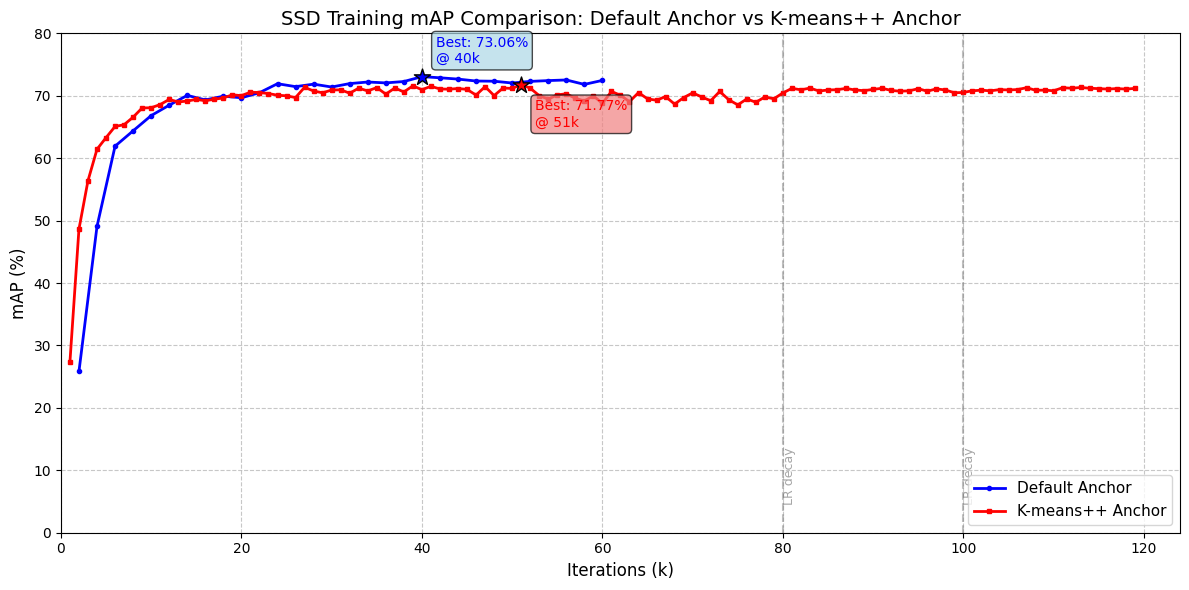


图像已保存到: outputs/mAP_comparison.png


In [4]:
# 创建图形
fig, ax = plt.subplots(figsize=(12, 6))

# 绘制曲线
ax.plot(default_iters / 1000, default_mAPs * 100, 'b-', linewidth=2, label='Default Anchor', marker='o', markersize=3)
ax.plot(kmeans_iters / 1000, kmeans_mAPs * 100, 'r-', linewidth=2, label='K-means++ Anchor', marker='s', markersize=3)

# 标记最高点
default_max_idx = np.argmax(default_mAPs)
kmeans_max_idx = np.argmax(kmeans_mAPs)

ax.scatter(default_iters[default_max_idx] / 1000, default_mAPs[default_max_idx] * 100, 
           s=150, c='blue', marker='*', zorder=5, edgecolors='black', linewidths=1)
ax.scatter(kmeans_iters[kmeans_max_idx] / 1000, kmeans_mAPs[kmeans_max_idx] * 100, 
           s=150, c='red', marker='*', zorder=5, edgecolors='black', linewidths=1)

# 添加最高点标注
ax.annotate(f'Best: {default_mAPs[default_max_idx]*100:.2f}%\n@ {default_iters[default_max_idx]//1000}k', 
            xy=(default_iters[default_max_idx] / 1000, default_mAPs[default_max_idx] * 100),
            xytext=(10, 10), textcoords='offset points', fontsize=10, color='blue',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))

ax.annotate(f'Best: {kmeans_mAPs[kmeans_max_idx]*100:.2f}%\n@ {kmeans_iters[kmeans_max_idx]//1000}k', 
            xy=(kmeans_iters[kmeans_max_idx] / 1000, kmeans_mAPs[kmeans_max_idx] * 100),
            xytext=(10, -30), textcoords='offset points', fontsize=10, color='red',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))

# 设置图形属性
ax.set_xlabel('Iterations (k)', fontsize=12)
ax.set_ylabel('mAP (%)', fontsize=12)
ax.set_title('SSD Training mAP Comparison: Default Anchor vs K-means++ Anchor', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlim(0, max(default_iters.max(), kmeans_iters.max()) / 1000 + 5)
ax.set_ylim(0, 80)

# 添加学习率衰减标记线
ax.axvline(x=80, color='gray', linestyle='--', alpha=0.5, label='LR decay @ 80k')
ax.axvline(x=100, color='gray', linestyle='--', alpha=0.5, label='LR decay @ 100k')
ax.text(80, 5, 'LR decay', rotation=90, fontsize=9, color='gray', alpha=0.7)
ax.text(100, 5, 'LR decay', rotation=90, fontsize=9, color='gray', alpha=0.7)

plt.tight_layout()
plt.savefig('outputs/mAP_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n图像已保存到: outputs/mAP_comparison.png")

In [5]:
# 输出最高 mAP 结果
print("=" * 60)
print("训练过程最高 mAP 结果汇总")
print("=" * 60)

print(f"\n【原始 Anchor 模型 (Default Anchor)】")
print(f"  最高 mAP: {default_mAPs.max() * 100:.2f}%")
print(f"  达到最高 mAP 的迭代次数: {default_iters[default_max_idx]:,}")
print(f"  最终 mAP (最后一次评估): {default_mAPs[-1] * 100:.2f}%")

print(f"\n【K-means++ Anchor 模型】")
print(f"  最高 mAP: {kmeans_mAPs.max() * 100:.2f}%")
print(f"  达到最高 mAP 的迭代次数: {kmeans_iters[kmeans_max_idx]:,}")
print(f"  最终 mAP (最后一次评估): {kmeans_mAPs[-1] * 100:.2f}%")

print(f"\n【对比结论】")
diff = default_mAPs.max() - kmeans_mAPs.max()
if diff > 0:
    print(f"  原始 Anchor 模型最高 mAP 比 K-means++ 高 {diff * 100:.2f}%")
else:
    print(f"  K-means++ Anchor 模型最高 mAP 比原始 Anchor 高 {-diff * 100:.2f}%")
print("=" * 60)

训练过程最高 mAP 结果汇总

【原始 Anchor 模型 (Default Anchor)】
  最高 mAP: 73.06%
  达到最高 mAP 的迭代次数: 40,000
  最终 mAP (最后一次评估): 72.46%

【K-means++ Anchor 模型】
  最高 mAP: 71.77%
  达到最高 mAP 的迭代次数: 51,000
  最终 mAP (最后一次评估): 71.18%

【对比结论】
  原始 Anchor 模型最高 mAP 比 K-means++ 高 1.29%


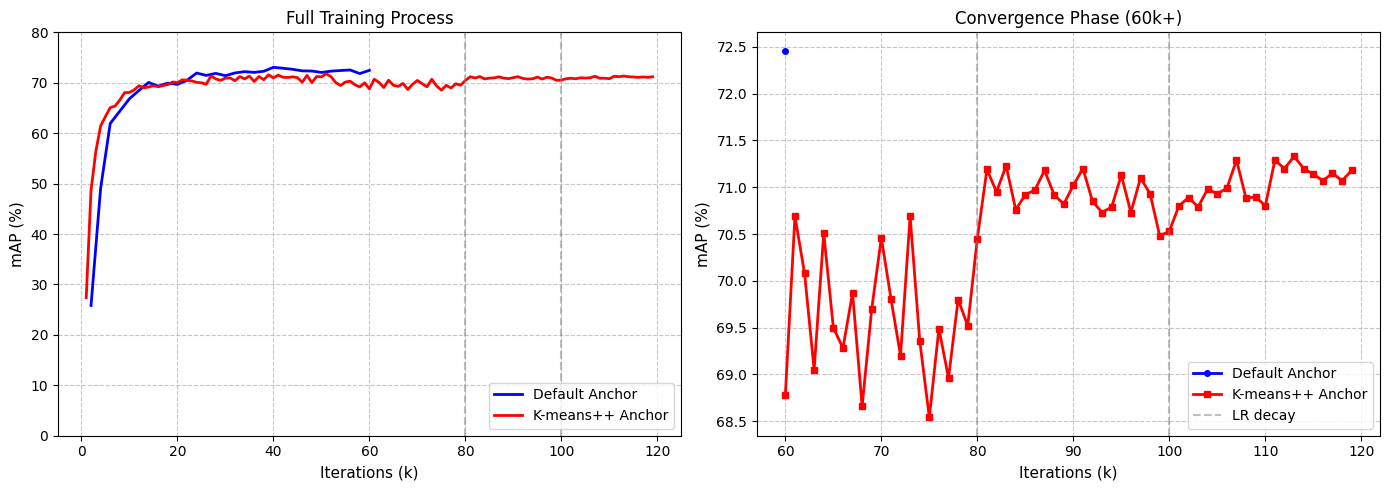


详细对比图已保存到: outputs/mAP_comparison_detailed.png


In [6]:
# 绘制更详细的对比图：包含各阶段分析
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 子图1：完整训练过程
ax1 = axes[0]
ax1.plot(default_iters / 1000, default_mAPs * 100, 'b-', linewidth=2, label='Default Anchor')
ax1.plot(kmeans_iters / 1000, kmeans_mAPs * 100, 'r-', linewidth=2, label='K-means++ Anchor')
ax1.axvline(x=80, color='gray', linestyle='--', alpha=0.5)
ax1.axvline(x=100, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Iterations (k)', fontsize=11)
ax1.set_ylabel('mAP (%)', fontsize=11)
ax1.set_title('Full Training Process', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(0, 80)

# 子图2：后期收敛阶段放大
ax2 = axes[1]
mask_default = default_iters >= 60000
mask_kmeans = kmeans_iters >= 60000
ax2.plot(default_iters[mask_default] / 1000, default_mAPs[mask_default] * 100, 'b-o', 
         linewidth=2, markersize=4, label='Default Anchor')
ax2.plot(kmeans_iters[mask_kmeans] / 1000, kmeans_mAPs[mask_kmeans] * 100, 'r-s', 
         linewidth=2, markersize=4, label='K-means++ Anchor')
ax2.axvline(x=80, color='gray', linestyle='--', alpha=0.5, label='LR decay')
ax2.axvline(x=100, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Iterations (k)', fontsize=11)
ax2.set_ylabel('mAP (%)', fontsize=11)
ax2.set_title('Convergence Phase (60k+)', fontsize=12)
ax2.legend(loc='lower right')
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('outputs/mAP_comparison_detailed.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n详细对比图已保存到: outputs/mAP_comparison_detailed.png")

In [7]:
# 统计数据表格
print("\n" + "=" * 70)
print("训练过程统计数据")
print("=" * 70)
print(f"{'指标':<25} {'Default Anchor':>18} {'K-means++ Anchor':>18}")
print("-" * 70)
print(f"{'最高 mAP':<25} {default_mAPs.max()*100:>17.2f}% {kmeans_mAPs.max()*100:>17.2f}%")
print(f"{'最终 mAP':<25} {default_mAPs[-1]*100:>17.2f}% {kmeans_mAPs[-1]*100:>17.2f}%")
print(f"{'平均 mAP (全程)':<25} {default_mAPs.mean()*100:>17.2f}% {kmeans_mAPs.mean()*100:>17.2f}%")
print(f"{'平均 mAP (60k后)':<25} {default_mAPs[default_iters>=60000].mean()*100:>17.2f}% {kmeans_mAPs[kmeans_iters>=60000].mean()*100:>17.2f}%")
print(f"{'mAP 标准差 (60k后)':<25} {default_mAPs[default_iters>=60000].std()*100:>17.4f}% {kmeans_mAPs[kmeans_iters>=60000].std()*100:>17.4f}%")
print(f"{'达到最高 mAP 的迭代次数':<25} {default_iters[default_max_idx]:>17,} {kmeans_iters[kmeans_max_idx]:>17,}")
print("=" * 70)


训练过程统计数据
指标                            Default Anchor   K-means++ Anchor
----------------------------------------------------------------------
最高 mAP                                73.06%             71.77%
最终 mAP                                72.46%             71.18%
平均 mAP (全程)                           68.60%             69.50%
平均 mAP (60k后)                         72.46%             70.51%
mAP 标准差 (60k后)                       0.0000%            0.7642%
达到最高 mAP 的迭代次数                       40,000            51,000


In [8]:
# !python test.py --config-file configs/vgg_ssd512_voc0712.yaml --ckpt outputs/vgg_ssd512_voc0712/model_final.pth MODEL.BACKBONE.PRETRAINED False TEST.BATCH_SIZE 256

2025-12-10 10:30:38,769 SSD INFO: Using 1 GPUs
2025-12-10 10:30:38,770 SSD INFO: Namespace(config_file='configs/vgg_ssd512_voc0712.yaml', local_rank=0, ckpt='outputs/vgg_ssd512_voc0712/model_final.pth', output_dir='eval_results', opts=['MODEL.BACKBONE.PRETRAINED', 'False', 'TEST.BATCH_SIZE', '256'])
2025-12-10 10:30:38,770 SSD INFO: Loaded configuration file configs/vgg_ssd512_voc0712.yaml
2025-12-10 10:30:38,771 SSD INFO: 
MODEL:
  NUM_CLASSES: 21
  BACKBONE:
    OUT_CHANNELS: (512, 1024, 512, 256, 256, 256, 256)
  PRIORS:
    FEATURE_MAPS: [64, 32, 16, 8, 4, 2, 1]
    STRIDES: [8, 16, 32, 64, 128, 256, 512]
    MIN_SIZES: [35.84, 76.8, 153.6, 230.4, 307.2, 384.0, 460.8]
    MAX_SIZES: [76.8, 153.6, 230.4, 307.2, 384.0, 460.8, 537.65]
    ASPECT_RATIOS: [[2], [2, 3], [2, 3], [2, 3], [2, 3], [2], [2]]
    BOXES_PER_LOCATION: [4, 6, 6, 6, 6, 4, 4]
INPUT:
  IMAGE_SIZE: 512
DATASETS:
  TRAIN: ("voc_2007_trainval",)
  TEST: ("voc_2007_test", )
SOLVER:
  MAX_ITER: 120000
  LR_STEPS: [80000,